## INF367 Mandatory Assignment 2

<p style="text-align:right;"><b>Written by:</b> Tobias Husebø, Lasse Holt, Martin Flo Øfstaas</p>
    <p style="text-align:right;"><i>Due: 8th of November 2024, (12:00)</i></p>

NB! look in notebook for more in-detail report

---

### Imports

We start of by declaring all imports used in the assignment.


In [1]:
# SKLEARN:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# QISKIT:
#...

# PANDAS:
import pandas as pd

# NUMPY:
import numpy as np

# MATPLOTLIB:
import matplotlib.pyplot as plt

---

&nbsp;

### Data initialization:

We start of by initializing our dataset. We do this via sklearns `load_iris()`. Furthermore we wish to explore the entirety of the dataset and not only the training subset. There is a few reasons for this. Firstly, the dataset is already relatively small. This means that splitting it via `train_test_split()` may not provide a represenative view of its characteristics. Thus, data exploration on the training subset may yield skewed pictures of what the data actually looks like. Secondly, the iris dataset is well-known and most of us has already worked with it, meaning concerns about data leakage are minimal.

In [2]:
# Loading the dataset:
data = load_iris()
X = data.data
y = data.target

---

&nbsp;

### Data Exploration:

In our data exploration step, we start of by looking at some fundamental properties of the dataset. Namely, missing values, label distribution and more. This leads to valuable insight which in return may help us choose a preformance metric, which encoding to utilize and etc.

We start of by defining some functions for the data exploration:

In [3]:
features = data.feature_names
labels = data.target_names
num_datapoints = len(X)
num_dims = len(features)


# Print the counts of datapoints, dims and alike
def dataset_counts(X, y):
    out_string = f"\nThe dataset contains {num_datapoints} datapoints"
    out_string += f"\nThe dataset contains {len(features)} dimensions\n\n"
    
    for i in range(len(features)):
        out_string += f"Feature {i+1}: {features[i]}\n"
        out_string += f"Feature {i+1} value interval [{np.min(X[:,i])}, {np.max(X[:,i])}]\n\n"
    
    print(out_string)
    

# Print out missing values (if any)
def missing_values_dataset(X, y):
    missing_X = np.isnan(X).any()
    missing_y = np.isnan(y).any()
    
    if missing_X or missing_y:
        print("The dataset contains one or more missing values.")
    else:
        print("The dataset is complete.")
        
        
# Visualize label distribution
def feature_count_distribution(X):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    # Plot each feature in a separate subplot
    for i in range(len(features)):
        axes[i].hist(X[:, i], bins=20, color='blue', alpha=0.7)
        axes[i].set_title(f'{features[i]} distribution')
        axes[i].set_xlabel('Value')
        axes[i].grid(axis="y")
        axes[i].set_ylabel('Frequency')
        
    fig.suptitle('Fig 1 - Distribution of Each Feature in Iris Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    
# Visualize label distribution
def label_distribution(y):
    _, counts = np.unique(y, return_counts=True)
    ticks = [label for label in labels]
    colors = plt.cm.tab10.colors[:len(counts)] 
    
    
    plt.bar(np.arange(len(counts)), counts, tick_label=ticks, color=colors)
    plt.xlabel('Each distinct label')
    plt.ylabel('Label count')
    plt.grid(axis="y")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.title('Fig 2 - Distribution of Labels', fontsize=14, fontweight="bold")
    plt.show()

&nbsp;

After defining some functions we can utilize them to gain valuable insight:

In [4]:
dataset_counts(X, y)


The dataset contains 150 datapoints
The dataset contains 4 dimensions

Feature 1: sepal length (cm)
Feature 1 value interval [4.3, 7.9]

Feature 2: sepal width (cm)
Feature 2 value interval [2.0, 4.4]

Feature 3: petal length (cm)
Feature 3 value interval [1.0, 6.9]

Feature 4: petal width (cm)
Feature 4 value interval [0.1, 2.5]




In [5]:
missing_values_dataset(X, y)

The dataset is complete.


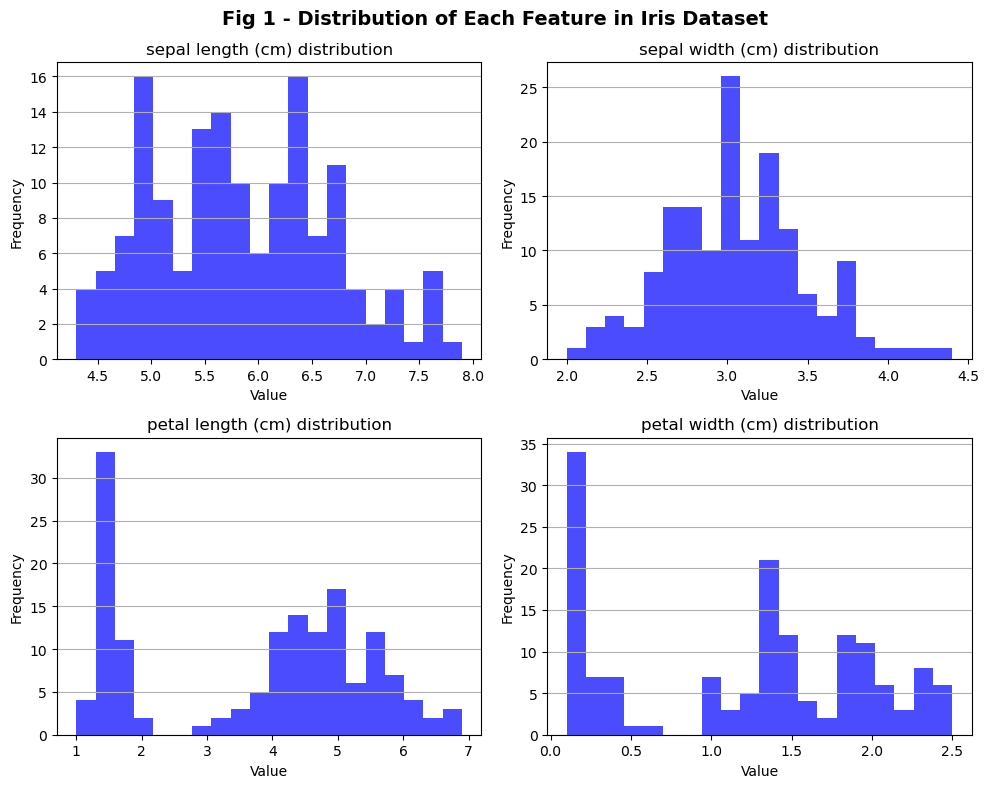

In [6]:
feature_count_distribution(X)

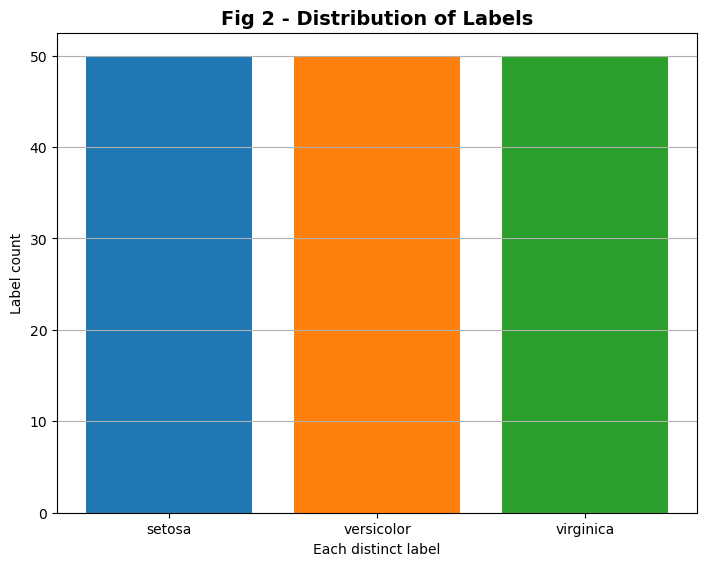

In [7]:
label_distribution(y)    

&nbsp;

After running our exploration functions we have gained some insight which will help us further on in the preprocessing / encoding step.

---

&nbsp;

### Data Preprocessing / Encoding:

#### PCA - Principal Component Analysis:

In our preprocessing stage we start of by visualizing the cumulative explained variance of each principal component, via the function `PCA_on_dataset(X):`

In [8]:
def PCA_on_dataset(X):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed)
    pca.fit(X)
    
    # Visualize the cumulative variance:
    svs = pca.singular_values_
    expl_variance = pca.explained_variance_ratio_
    
    plt.plot(np.arange(1, len(svs)+1, 1), [sum(expl_variance[:i+1])*100 for i in range(len(expl_variance))])
    plt.yticks(np.arange(80, 101, 1))
    plt.xticks(np.arange(1,len(svs)+0.1, 1))
    plt.ylim(78, 102)
    plt.xlabel("Number of PCs")
    plt.ylabel("Cumulative explained variance (%)")
    plt.title('Fig 3 - PCA on Dataset', fontsize=14, fontweight="bold")
    plt.grid()
    
    plt.show()
    

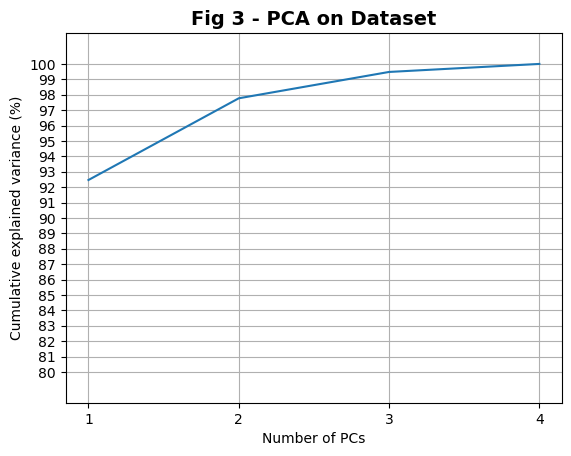

In [9]:
PCA_on_dataset(X)

Via looking at this it is clear that by utilizing only 2 of our 4 principal components we are able to capture `98%` of the information in the original dataset. Thus, we can simply project our datapoints on the axes´ formed by the first and second principal component to reduce the dimensionality and maintain almost all information in the dataset.

Thus, we reduce the dimensionality from 4 to 2 via `dim_reduction(X, num_PCs)`. Additionally, we can plot the data with `scatter_plot_2d_data(X, y)` to visualize that the first 2 PC´s capture most of the information:

In [10]:
def dim_reduction(X, num_PCs):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed, n_components=2)
    return pca.fit_transform(X)

X = dim_reduction(X, 2)

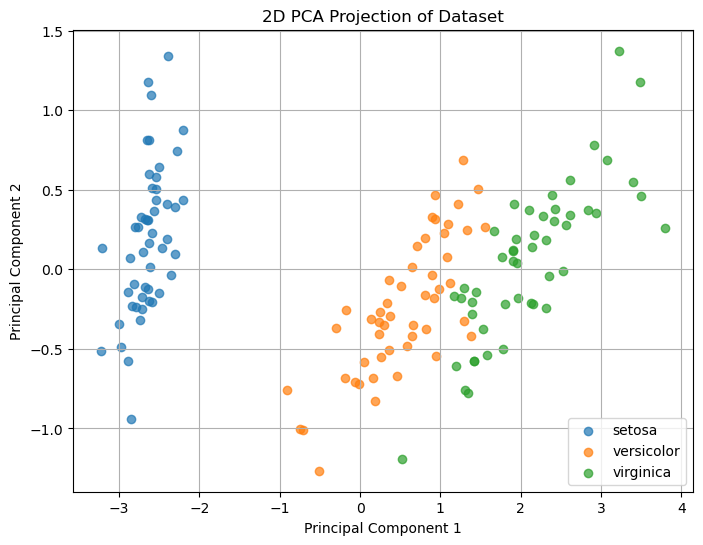

In [11]:
# Assuming `X` is the transformed data with 2 components and `y` contains the labels
def scatter_plot_2d_data(X, y, xlabel, ylabel, title, radian_ticks):
    # Define colors for each class
    colors = plt.cm.tab10.colors[:len(labels)] 
    labels_nr = [0, 1, 2]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each class with a different color
    for i, label in enumerate(labels_nr):
        plt.scatter(X[y == label, 0], X[y == label, 1], 
                    color=colors[i], label=f'{labels[i]}', alpha=0.7)
        
    if radian_ticks == True:
        ticks = np.linspace(0, 2 * np.pi, 5)  # Adjust the number of ticks as needed
        tick_labels = [f"{i:.2f}π" for i in np.linspace(0, 2, 5)]  # Labels like "0π", "0.5π", "1.0π", etc.

        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

scatter_plot_2d_data(X, y, "Principal Component 1", "Principal Component 2", "2D PCA Projection of Dataset", False)

&nbsp;

Now we have reduced the dimensionality of our datavector X, and furthermore plotted it. We can see from our plot that via applying PCA we have still retained most of the information in the original dataset as there appears clear clusters for each class.

---

&nbsp;

#### Scaling / Encoding:

In our implementation of the QNN we have concluded that angle encoding is the way to go for the dataset at hand. For further information on our choice look at the report. This means that we have to scale it on a scale from $ x \in [0, 2\pi]$ as information, because $\forall a, a + 2\pi = a$, meaning we can not distinguish between these values with angle encoding. Thus, we scale via sklearns `MinMaxScaler()` function. We also want to plot the data to see that we still have maintained the original "structure" of the dataset: 

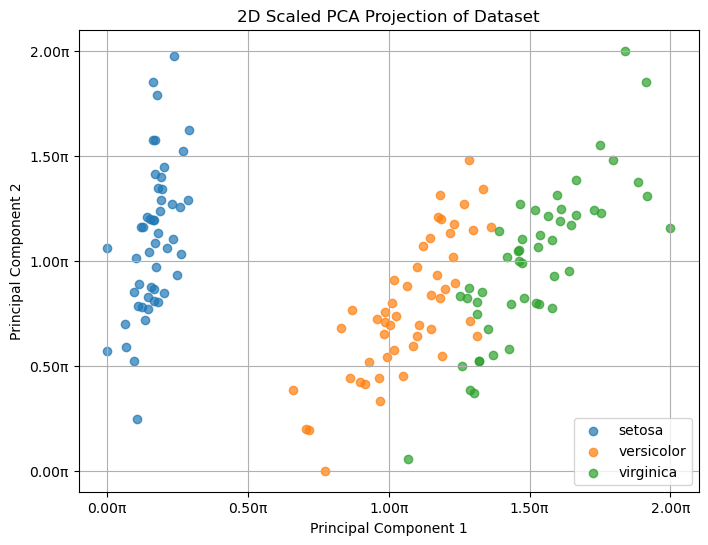

In [12]:
scaler = MinMaxScaler(feature_range=(0, 2*np.pi))
X = scaler.fit_transform(X)

scatter_plot_2d_data(X, y, "Principal Component 1", "Principal Component 2", "2D Scaled PCA Projection of Dataset", True)

After scaling the data from 